In [260]:
from pymongo import MongoClient
import matplotlib.pyplot as plt
import snappy
import numpy as np
%matplotlib inline

In [261]:
client = MongoClient()

### Radon analysis

In [262]:
dbname = 'xamsdata0'
collname = '170213_105309'
client[dbname][collname]

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'xamsdata0'), '170213_105309')

In [289]:
import pandas as pd
n_events = client[dbname][collname].count()//2
print('Maximum usable events now: %d' % n_events)
    
df = pd.DataFrame({'time': np.zeros(n_events), 
                   'time_ns': np.zeros(n_events, dtype=int), 
                   'baseline_ch0' : np.zeros(n_events),
                   'baseline_ch0_' : np.zeros(n_events),

                   'baseline_ch4' : np.zeros(n_events),
                   'plateau_ch0' : np.zeros(n_events),
                   'max_ch0' : np.zeros(n_events),
                   'min_ch4' : np.zeros(n_events),
                  })
                   

Maximum usable events now: 11613


In [290]:
cursor = client[dbname][collname].find()
i = 0
for doc in cursor:
    if i >= n_events * 2:
        break
    i_ev = i//2 # 2 channels
    # Get the data
    d = snappy.decompress(doc['data'])
    w = np.fromstring(d, dtype='<i2')
    # 
    if doc['channel'] == 0:
        # New event! Let us store all the relevant properties
        df.iloc[i_ev, df.columns.get_loc('time_ns')] = doc['time'] * 4
        df.iloc[i_ev, df.columns.get_loc('time')] = doc['time'] * 4 * 1e-9
        df.iloc[i_ev, df.columns.get_loc('baseline_ch0_')] = np.average(w[:100])
        df.iloc[i_ev, df.columns.get_loc('baseline_ch0')] = np.average(w[:250])

        df.iloc[i_ev, df.columns.get_loc('plateau_ch0')] = np.average(w[400:600])
        df.iloc[i_ev, df.columns.get_loc('max_ch0')] = max(w)
    if doc['channel'] == 4:
        df.iloc[i_ev, df.columns.get_loc('baseline_ch4')] = np.average(w[:100])
        df.iloc[i_ev, df.columns.get_loc('min_ch4')] = max(w)
    i+=1

In [291]:
df['amp'] = df['plateau_ch0'] - df['baseline_ch0']

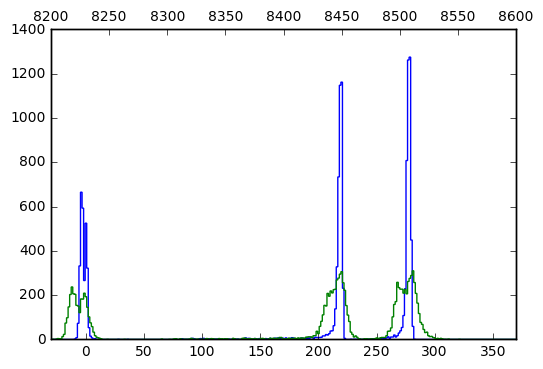

In [292]:
shift = 30
plt.hist(df['amp'], bins=300, histtype='step', 
         range=(-shift,400 - shift))
plt.xlim(-shift,400 - shift)
plt.twiny()
plt.hist(df['plateau_ch0'], bins=300, histtype='step', range=(8200,8600), color='green')
#plt.hist(df['baseline_ch0'], bins=300, histtype='step', range=(8200,8600))

# plt.yscale('log')
# plt.ylim(1,1e3)
plt.show()

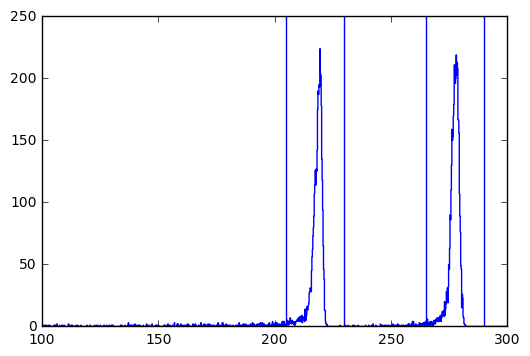

In [312]:
bin_counts, bin_edges, _ = plt.hist(df['amp'], 
                                    bins=1000, histtype='step', range=(100,300))
# plt.yscale('log')
# plt.ylim(1, 4e2)
plt.axvline(205)
plt.axvline(230)

plt.axvline(265)
plt.axvline(290)

plt.show()

In [311]:
def get_peak_properties(start_at, stop_at, bin_counts, bin_edges):
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    peak0_max = max(bin_counts[start_at:stop_at])
    peak0_index = start_at + np.argmax(bin_counts[start_at:stop_at])
    peak0_pos = bin_centers[peak0_index]
    i = peak0_index
    while bin_counts[i] >= 0.5 * peak0_max:
        i -= 1
    peak0_left = bin_centers[i]
    peak0_left_samples = i
    i = peak0_index
    while bin_counts[i] >= 0.5 * peak0_max:
        i += 1
    peak0_right = bin_centers[i]
    peak0_right_samples = i
    peak0_fwhm = (peak0_right - peak0_left) / peak0_pos * 100
    print('Returning properties of peak found at %.1f amplitude %d' % (peak0_pos, peak0_max))
    print('Total width in samples is %d' % (peak0_right_samples - peak0_left_samples))
    return peak0_fwhm

In [308]:
print(get_peak_properties(0, 700, bin_counts, bin_edges))
print(get_peak_properties(700, 1000, bin_counts, bin_edges))

Returning properties of peak found at 219.5 amplitude 224
Total width in samples is 18
1.64009111617
Returning properties of peak found at 278.1 amplitude 219
Total width in samples is 19
1.36641495865


In [296]:
df_0 = df[(df['amp'] > 205) & (df['amp'] < 230)]
df_1 = df[(df['amp'] > 265) & (df['amp'] < 290)]
print('Events in windows: %d (%.1f %%) and %d (%.1f %%)' % (len(df_0), 100*len(df_0)/len(df),
                                                        len(df_1), 100*len(df_1)/len(df)))

Events in windows: 3967 (34.2 %) and 4355 (37.5 %)


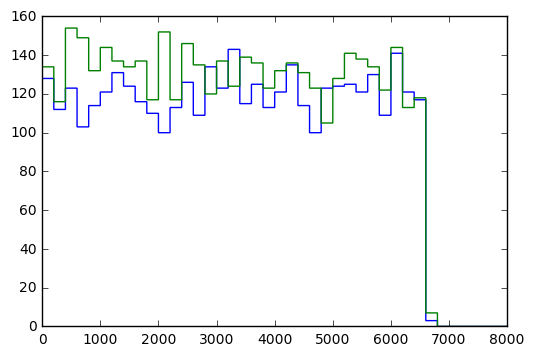

In [298]:
plt.hist(df_0['time'], histtype='step', bins=40, range=(0, 8000))
plt.hist(df_1['time'], histtype='step', bins=40, range=(0, 8000))
plt.yticks()
plt.show()